In [2]:
import os
import sys
import pandas as pd
import numpy as np
from importlib import reload
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from jinja2 import Template
import sqlalchemy
import yaml
%matplotlib inline

In [2]:
df = pd.read_csv('/mnt/data/experiment_data/elsal/SAMPLING_DETAILS_DATAFRAME.csv')

In [5]:
df.head()
df.columns

Index(['Unnamed: 0', 'mode', 'ratio_protected', 'ldist_p', 'ldist_np',
       'min_as_of_date', 'max_as_of_date', 'train_matrix_id', 'test_matrix_id',
       'orig_p_l0', 'orig_p_l1', 'orig_np_l0', 'orig_np_l1', 'sampled_p_l0',
       'sampled_p_l1', 'sampled_np_l0', 'sampled_np_l1'],
      dtype='object')

In [13]:
df[(df['mode']=='under')&(df['ratio_protected']=='original')][['min_as_of_date', 'ratio_protected','ldist_p','ldist_np','orig_p_l0','orig_p_l1','orig_np_l0', 'orig_np_l1', 
                           'sampled_p_l0','sampled_p_l1', 'sampled_np_l0','sampled_np_l1']]

,min_as_of_date,ratio_protected,ldist_p,ldist_np,orig_p_l0,orig_p_l1,orig_np_l0,orig_np_l1,sampled_p_l0,sampled_p_l1,sampled_np_l0,sampled_np_l1
28,2015-01-01,original,50,50,1275.0,1144.0,257699.0,37993.0,310,310,37993,37993
29,2014-01-01,original,50,50,1181.0,1268.0,251686.0,58050.0,458,458,58050,58050
30,2013-01-01,original,50,50,1379.0,1975.0,253238.0,68635.0,715,715,68635,68635
31,2012-01-01,original,50,50,1140.0,1798.0,200686.0,72028.0,775,775,72028,72028
32,2011-01-01,original,50,50,1438.0,2401.0,210131.0,109931.0,1318,1318,109931,109931
33,2010-01-01,original,50,50,1727.0,2130.0,205928.0,101028.0,1269,1269,101028,101028
34,2009-01-01,original,50,50,1873.0,705.0,181039.0,62392.0,660,660,62392,62392
35,2009-01-01,original,50,50,1873.0,705.0,181039.0,62392.0,660,660,62392,62392
36,2010-01-01,original,50,50,1727.0,2130.0,205928.0,101028.0,1269,1269,101028,101028
37,2011-01-01,original,50,50,1438.0,2401.0,210131.0,109931.0,1318,1318,109931,109931


In [5]:
def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('../..','config'), 'elsal_db_profile2.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)
conn = connect()

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


## Plotting Code

In [12]:
query = Template("""
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {{schema}}.model_adjustment_results_ovg
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)

-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_0_to_1 AS recall_0_to_1,
       r.base_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_0_to_1 AS recall_0_to_1,
       r.adj_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_0_to_1 AS recall_0_to_1,
       r.adj_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      r.train_end_time AS train_end_time,
      r.past_train_end_time AS past_train_end_time,
      r.list_size, metric, parameter,
      r.value AS value,
      r.max_recall_ratio AS max_recall_ratio,
      r.recall_0_to_1 AS recall_0_to_1,
      r.recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.composite_results_ovg r
WHERE train_end_time > past_train_end_time
;
""")

In [26]:
def plot(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(12, 5))
    
    data = comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 style = 'strategy',
                 markers = True,
                 color = colorlist,
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = np.unique(data['dataset'])
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=16)
    ax.set_xlabel('Precision at Top-K', fontsize=16)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []
    for i, lab in enumerate(labels):
        if lab not in list(unique_dfs) + ['dataset', 'strategy']:
            handles[i].set_linestyle("")
        hhandles.append(handles[i])
        llabels.append(lab)
        
    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    #ax.set_ylim([0.5, 2.5])
    fig.tight_layout()

In [17]:
params = {}
params['schema'] = 'bias_analysis_v2_original'
sql_orig = query.render(**params)
ts_df_orig = pd.read_sql(sql_orig, conn)

In [85]:
params = {}
params['schema'] = 'bias_analysis_v2_zafar'
sql_zafar = query.render(**params)
ts_df_zafar = pd.read_sql(sql_zafar, conn)

In [18]:
params = {}
params['schema'] = 'bias_analysis_v2_under_1_orig_orig'
sql_v1a = query.render(**params)
ts_df_v1a = pd.read_sql(sql_v1a, conn)

In [21]:
params = {}
params['schema'] = 'bias_analysis_v2_under_orig_50_orig'
sql_v2c = query.render(**params)
ts_df_v2c = pd.read_sql(sql_v2c, conn)

In [40]:
params = {}
params['schema'] = 'bias_analysis_v2_under_orig_snop_orig'
sql_v2b = query.render(**params)
ts_df_v2b = pd.read_sql(sql_v2b, conn)

In [41]:
params = {}
params['schema'] = 'bias_analysis_v2_under_orig_50_50'
sql_v2a = query.render(**params)
ts_df_v2a = pd.read_sql(sql_v2a, conn)

In [42]:
params = {}
params['schema'] = 'bias_analysis_v2_under_1_snop_orig'
sql_v3a = query.render(**params)
ts_df_v3a = pd.read_sql(sql_v3a, conn)

In [43]:
params = {}
params['schema'] = 'bias_analysis_v2_under_1_50_50'
sql_v3b = query.render(**params)
ts_df_v3b = pd.read_sql(sql_v3b, conn)

In [58]:
params = {}
params['schema'] = 'bias_analysis_v2_over_1_orig_orig'
sql_o_v1a = query.render(**params)
ts_df_o_v1a = pd.read_sql(sql_o_v1a, conn)

In [60]:
params = {}
params['schema'] = 'bias_analysis_v2_over_orig_50_50'
sql_o_v2a = query.render(**params)
ts_df_o_v2a = pd.read_sql(sql_o_v2a, conn)

In [61]:
params = {}
params['schema'] = 'bias_analysis_v2_over_orig_snop_orig'
sql_o_v2b = query.render(**params)
ts_df_o_v2b = pd.read_sql(sql_o_v2b, conn)

In [62]:
params = {}
params['schema'] = 'bias_analysis_v2_over_orig_50_orig'
sql_o_v2c = query.render(**params)
ts_df_o_v2c = pd.read_sql(sql_o_v2c, conn)

In [63]:
params = {}
params['schema'] = 'bias_analysis_v2_over_1_snop_orig'
sql_o_v3a = query.render(**params)
ts_df_o_v3a = pd.read_sql(sql_o_v3a, conn)

In [64]:
params = {}
params['schema'] = 'bias_analysis_v2_over_1_50_50'
sql_o_v3b = query.render(**params)
ts_df_o_v3b = pd.read_sql(sql_o_v3b, conn)

In [66]:
params = {}
params['schema'] = 'bias_analysis_v2_nop'
sql_nop = query.render(**params)
ts_df_nop = pd.read_sql(sql_nop, conn)

In [67]:
params = {}
params['schema'] = 'bias_analysis_v2_decoupled'
sql_decoupled = query.render(**params)
ts_df_decoupled = pd.read_sql(sql_decoupled, conn)

In [86]:
ts_df_nop['dataset'] = 'NoP'
nop_df = ts_df_nop.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_decoupled['dataset'] = 'Decoupled'
decoupled_df = ts_df_decoupled.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_zafar['dataset'] = 'Zafar'
zafar_df = ts_df_zafar.rename(
    {'recall_1_to_0': 'recall_disp'}, axis='columns')

In [80]:
ts_df_orig['dataset'] = 'Original'
orig_df = ts_df_orig.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v1a['dataset'] = 'U-v1a'
u_v1a_df = ts_df_v1a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v2a['dataset'] = 'U-v2a'
u_v2a_df = ts_df_v2a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v2b['dataset'] = 'U-v2b'
u_v2b_df = ts_df_v2b.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v2c['dataset'] = 'U-v2c'
u_v2c_df = ts_df_v2c.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v3a['dataset'] = 'U-v3a'
u_v3a_df = ts_df_v3a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v3b['dataset'] = 'U-v3b'
u_v3b_df = ts_df_v3b.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

In [65]:
ts_df_o_v1a['dataset'] = 'O-v1a'
o_v1a_df = ts_df_o_v1a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v2a['dataset'] = 'O-v2a'
o_v2a_df = ts_df_o_v2a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v2b['dataset'] = 'O-v2b'
o_v2b_df = ts_df_o_v2b.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v2c['dataset'] = 'O-v2c'
o_v2c_df = ts_df_o_v2c.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v3a['dataset'] = 'O-v3a'
o_v3a_df = ts_df_o_v3a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v3b['dataset'] = 'O-v3b'
o_v3b_df = ts_df_o_v3b.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

In [87]:
original_df = pd.concat([orig_df, nop_df, decoupled_df, zafar_df])
under_df = pd.concat([orig_df, u_v1a_df, u_v2a_df, u_v2b_df, u_v2c_df, u_v3a_df, u_v3b_df])
over_df = pd.concat([orig_df, o_v1a_df, o_v2a_df, o_v2b_df, o_v2c_df, o_v3a_df, o_v3b_df])

all_df = pd.concat([orig_df, nop_df, decoupled_df, u_v1a_df, u_v2a_df, u_v2b_df, u_v2c_df, u_v3a_df, u_v3b_df, 
                    o_v1a_df, o_v2a_df, o_v2b_df, o_v2c_df, o_v3a_df, o_v3b_df])

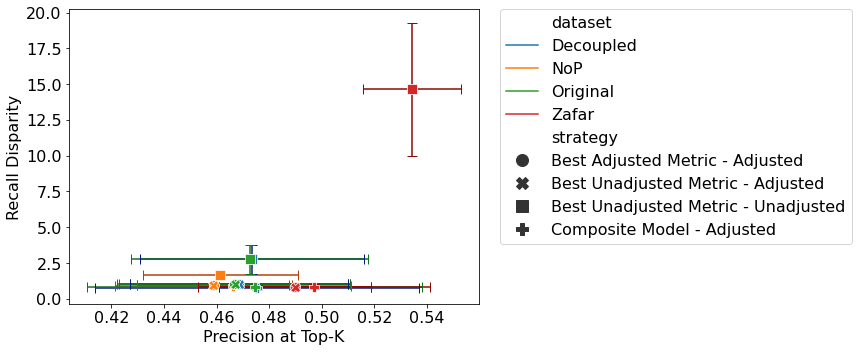

In [89]:
plot(original_df)

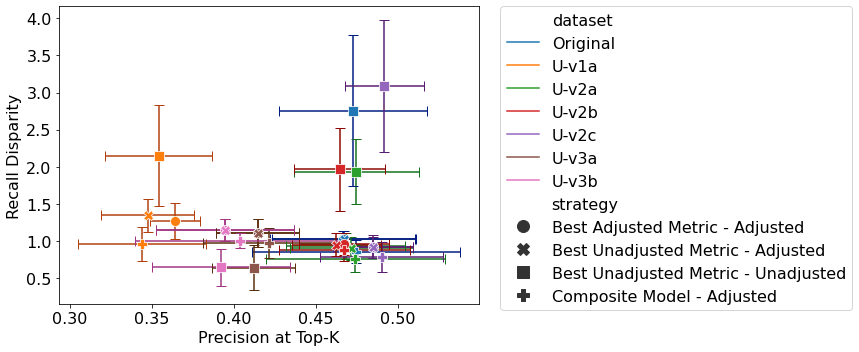

In [90]:
plot(under_df)

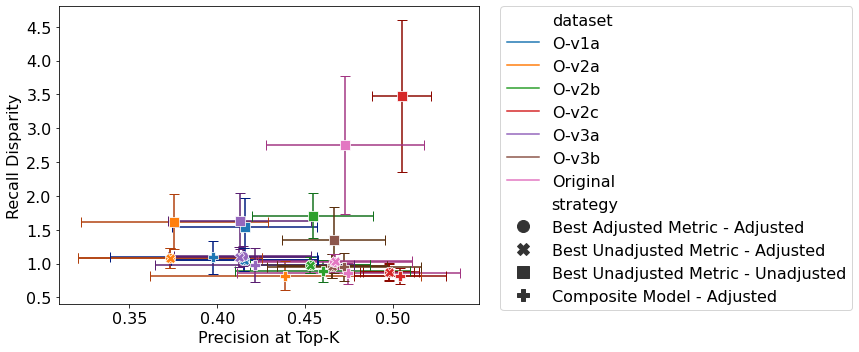

In [91]:
plot(over_df)

In [75]:
data = all_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()

In [78]:
data[data['strategy'] == 'Best Unadjusted Metric - Unadjusted'].sort_values(by=['value'])

,dataset,strategy,value,recall_disp
38,U-v1a,Best Unadjusted Metric - Unadjusted,0.354234,2.149039
14,O-v2a,Best Unadjusted Metric - Unadjusted,0.375695,1.616944
58,U-v3b,Best Unadjusted Metric - Unadjusted,0.392134,0.648557
54,U-v3a,Best Unadjusted Metric - Unadjusted,0.412178,0.643758
26,O-v3a,Best Unadjusted Metric - Unadjusted,0.412773,1.623590
10,O-v1a,Best Unadjusted Metric - Unadjusted,0.415542,1.535484
18,O-v2b,Best Unadjusted Metric - Unadjusted,0.454149,1.707012
6,NoP,Best Unadjusted Metric - Unadjusted,0.461366,1.689152
46,U-v2b,Best Unadjusted Metric - Unadjusted,0.464575,1.968045
30,O-v3b,Best Unadjusted Metric - Unadjusted,0.466202,1.345757


## Saving DataFrames

In [95]:
def to_pickle(df, name):
    df.to_pickle('/mnt/data/experiment_data/elsal_new/SAVED_DFS/'+str(name)+'.pkl')
    
to_pickle(orig_df, 'orig_df')
to_pickle(nop_df, 'nop_df')
to_pickle(decoupled_df, 'decoupled_df')
to_pickle(zafar_df, 'zafar_df')

to_pickle(u_v1a_df, 'u_v1a_df')
to_pickle(u_v2a_df, 'u_v2a_df')
to_pickle(u_v2b_df, 'u_v2b_df')
to_pickle(u_v2c_df, 'u_v2c_df')
to_pickle(u_v3a_df, 'u_v3a_df')
to_pickle(u_v3b_df, 'u_v3b_df')

to_pickle(o_v1a_df, 'o_v1a_df')
to_pickle(o_v2a_df, 'o_v2a_df')
to_pickle(o_v2b_df, 'o_v2b_df')
to_pickle(o_v2c_df, 'o_v2c_df')
to_pickle(o_v3a_df, 'o_v3a_df')
to_pickle(o_v3b_df, 'o_v3b_df')

### Experiment Run Analysis

In [17]:
query = Template("""
select distinct(model_group_id) from triage_metadata.models where built_by_experiment='{{exp_hash}}'
""")

query_all_models = Template("""
select distinct(model_id) from triage_metadata.models where built_by_experiment in ('{{exp1}}', '{{exp2}}')
""")

In [18]:
params = {}
params['exp_hash'] = 'a1316f404aecc9df9e3c5264b32770f8'
mg_orig_basic = set(pd.read_sql(query.render(**params), conn)['model_group_id'].values)

params = {}
params['exp_hash'] = '290f77e278ed5b3ef07ad7e0f33fafc0'
mg_orig_rf = set(pd.read_sql(query.render(**params), conn)['model_group_id'].values)


params = {}
params['exp_hash'] = '39a8ce8f1a99004d0112eeb29e78ccf5'
mg_o15050_basic = set(pd.read_sql(query.render(**params), conn)['model_group_id'].values)

params = {}
params['exp_hash'] = 'e82ada1518d6ebc3ce3b93c57e84bb53'
mg_o15050_rf = set(pd.read_sql(query.render(**params), conn)['model_group_id'].values)

params = {}
params['exp1'] = 'a1316f404aecc9df9e3c5264b32770f8'
params['exp2'] = '290f77e278ed5b3ef07ad7e0f33fafc0'
models_orig = set(pd.read_sql(query_all_models.render(**params), conn)['model_id'].values)

params = {}
params['exp1'] = '39a8ce8f1a99004d0112eeb29e78ccf5'
params['exp2'] = 'e82ada1518d6ebc3ce3b93c57e84bb53'
models_o15050 = set(pd.read_sql(query_all_models.render(**params), conn)['model_id'].values)


In [12]:
len(mg_orig_basic.intersection(mg_o15050_basic)), len(mg_orig_basic)

(73, 73)

In [14]:
len(mg_orig_rf.intersection(mg_o15050_rf)), len(mg_orig_rf), len(mg_o15050_rf)

(16, 36, 16)

In [19]:
len(models_orig)

919

In [20]:
len(models_o15050)

623